# Trader Joe's products

#### Load Python tools and Jupyter config

In [40]:
import os
import json
import time
import boto3
import logging
import requests
import pandas as pd
import jupyter_black
import altair as alt
from io import BytesIO
import plotly.express as px
from tqdm.notebook import tqdm
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# jupyter_black.load()
# pd.options.display.max_columns = 100
# pd.options.display.max_rows = 10000
# pd.options.display.max_colwidth = None

In [3]:
today = pd.Timestamp("today").strftime("%Y%m%d")
year = pd.Timestamp("today").strftime("%Y")

In [4]:
# Set up basic configuration for logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [5]:
# Determine if running in a GitHub Actions environment
is_github_actions = os.getenv("GITHUB_ACTIONS") == "true"

In [6]:
# AWS credentials and session initialization
aws_key_id = os.environ.get("MY_AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("MY_AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("MY_AWS_DEFAULT_REGION")
aws_profile = os.environ.get("MY_AWS_PERSONAL_PROFILE")

In [7]:
# Conditional AWS session creation based on the environment
if is_github_actions:
    # In GitHub Actions, use environment variables directly
    session = boto3.Session(
        aws_access_key_id=aws_key_id,
        aws_secret_access_key=aws_secret_key,
        region_name=aws_region,
    )
else:
    # Locally, use a specific profile
    session = boto3.Session(profile_name=aws_profile, region_name=aws_region)

s3_resource = session.resource("s3")

# Base directory settings
base_dir = os.getcwd()
data_dir = os.path.join(base_dir)

---

In [8]:
# Import store locations
loc_df = pd.read_json(
    "https://raw.githubusercontent.com/stiles/locations/main/trader-joes/data/processed/trader_joes_locations.json"
)

In [9]:
# Get random location(s) to check its prices
locations_to_check = 1
stores_list = loc_df["store_number"].sample(locations_to_check).to_list()

# My store in LA and one in the middle of the country: Kansas City
# stores_list = ["119"]
# stores_list = ["720"]

---

In [10]:
# Function to safely join list elements
def safe_join(iterable, separator=", "):
    return separator.join(iterable) if iterable else ""

In [11]:
# Function to fetch paginated product data for a given store code
def fetch_paginated_products(store_code, page_size=100):
    query = """
    query SearchProducts(
        $categoryId: String,
        $currentPage: Int,
        $pageSize: Int,
        $storeCode: String = "250",
        $availability: String = "1",
        $published: String = "1"
    ) {
      products(
        filter: {
          store_code: {eq: $storeCode},
          published: {eq: $published},
          availability: {match: $availability},
          category_id: {eq: $categoryId}
        },
        currentPage: $currentPage,
        pageSize: $pageSize
      ) {
        items {
          sku
          item_title
          category_hierarchy {
            id
            name
            __typename
          }
          primary_image
          primary_image_meta {
            url
            metadata
            __typename
          }
          sales_size
          sales_uom_description
          price_range {
            minimum_price {
              final_price {
                currency
                value
                __typename
              }
              __typename
            }
            __typename
          }
          retail_price
          fun_tags
          item_characteristics
          __typename
        }
      }
    }
    """

    current_page = 1
    all_products = []

    while True:
        variables = {
            "storeCode": store_code,
            "availability": "1",
            "published": "1",
            "categoryId": "2",  # Adjust as needed
            "currentPage": current_page,
            "pageSize": page_size,
        }

        json_data = {
            "operationName": "SearchProducts",
            "variables": variables,
            "query": query,
        }

        headers = {
            "Content-Type": "application/json",
        }

        response = requests.post(
            "https://www.traderjoes.com/api/graphql", headers=headers, json=json_data
        )

        if response.status_code == 200:
            data = response.json()
            products = data.get("data", {}).get("products", {}).get("items", [])
            if not products:
                break
            all_products.extend(products)
            current_page += 1
        else:
            print(
                f"Request failed for store {store_code} with status code {response.status_code}"
            )
            break

    return all_products

In [12]:
# Function to flatten product data and add store code
def flatten_product_data(product, store_code):
    return {
        "store_code": store_code,
        "sku": product.get("sku"),
        "item_title": product.get("item_title"),
        "primary_image": product.get("primary_image"),
        "primary_image_url": product.get("primary_image_meta", {}).get("url"),
        "sales_size": product.get("sales_size"),
        "sales_uom_description": product.get("sales_uom_description"),
        "final_price": product.get("price_range", {})
        .get("minimum_price", {})
        .get("final_price", {})
        .get("value"),
        "retail_price": product.get("retail_price"),
        "fun_tags": safe_join(
            product.get("fun_tags", [])
        ),  # Safely join list into a string
        "item_characteristics": safe_join(
            product.get("item_characteristics", [])
        ),  # Safely join list into a string
        "category_hierarchy": safe_join(
            [cat.get("name") for cat in product.get("category_hierarchy", [])], " > "
        ),  # Safely join categories
    }

In [13]:
# Function to compile all product data using concurrent requests
def compile_all_products_concurrent(stores_list, page_size=100):
    all_products = []

    def fetch_store_products(store_code):
        return [
            (store_code, product)
            for product in fetch_paginated_products(store_code, page_size)
        ]

    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_store = {
            executor.submit(fetch_store_products, store_code): store_code
            for store_code in stores_list
        }
        for future in as_completed(future_to_store):
            store_code = future_to_store[future]
            try:
                products = future.result()
                for store_code, product in products:
                    flattened_product = flatten_product_data(product, store_code)
                    all_products.append(flattened_product)
            except Exception as exc:
                print(f"Store {store_code} generated an exception: {exc}")

    # Convert the list of all products into a DataFrame
    products_df = pd.DataFrame(all_products)

    return products_df

In [14]:
# Fetch and compile product data
products_df = compile_all_products_concurrent(stores_list, page_size=100)

In [15]:
# Ensure the 'storeCode' column exists in loc_df for merging
loc_df = loc_df.rename(columns={"storeCode": "store_number"})

In [16]:
# Merge with loc_df to get location information
df = pd.merge(
    products_df,
    loc_df[["name", "store_number"]],
    left_on="store_code",
    right_on="store_number",
)

In [17]:
df[["final_price", "retail_price"]] = df[["final_price", "retail_price"]].astype(
    "float"
)

In [ ]:
df[["drop", "prod_cat", "prod_cat_type", "prod_cat_desc"]] = df[
    "category_hierarchy"
].str.split(">", expand=True)

---

## Aggregate

In [37]:
df['prod_cat_desc'] = df['prod_cat_desc'].fillna('None')

In [38]:
agg_df = df.groupby(['prod_cat', 'prod_cat_type', 'prod_cat_desc']).size().reset_index(name='count')

In [ ]:
agg_df

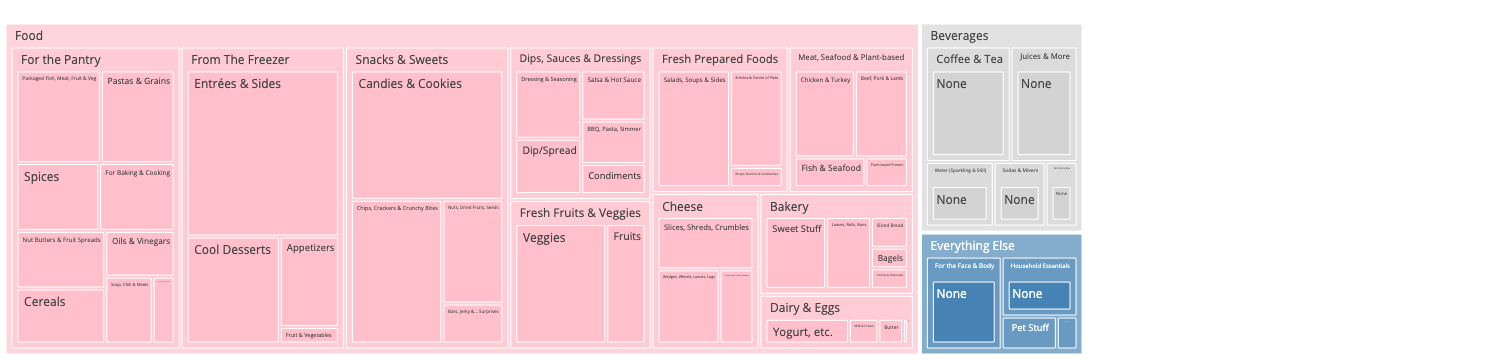

In [55]:
# Create the tree map
fig = px.treemap(
    agg_df,
    path=['prod_cat', 'prod_cat_type', 'prod_cat_desc'],
    values='count',
)

# Display the tree map
fig.update_layout(treemapcolorway = ["pink", "lightgray", 'steelblue'], margin = dict(t=0, l=0, r=400, b=0))
fig.show()

---

## Exports

#### JSON

In [20]:
df.to_json(
    f"data/processed/products.json",
    indent=4,
    orient="records",
)

#### CSV

In [21]:
df.to_csv(
    f"data/processed/products.csv", index=False
)

#### S3

In [22]:
# Function to save DataFrame to S3
def save_to_s3(df, base_path, s3_bucket, formats):
    for fmt in formats:
        try:
            buffer = BytesIO()
            if fmt == "csv":
                df.to_csv(buffer, index=False)
                content_type = "text/csv"
            elif fmt == "json":
                df.to_json(buffer, indent=4, orient="records", lines=False)
                content_type = "application/json"
            elif fmt == "parquet":
                df.to_parquet(buffer, index=False)
                content_type = "application/octet-stream"
            buffer.seek(0)
            s3_resource.Bucket(s3_bucket).put_object(
                Key=f"{base_path}.{fmt}", Body=buffer, ContentType=content_type
            )
            logging.info(f"Uploaded {fmt} to {s3_bucket}/{base_path}.{fmt}")
        except Exception as e:
            logging.error(f"Failed to upload {fmt} to S3: {e}")


# Saving files locally and to S3
file_path = os.path.join(data_dir)
formats = ["csv", "json", "parquet"]
save_to_s3(
    df,
    "trader-joes/products",
    "stilesdata.com",
    formats,
)